In [1]:
# IMPORT LIBRARIES
using Distributions, Turing, StatsPlots, Random, RDatasets, CSV

### Assignment 2: hierarchical models

In [4]:
# FETCH WARP BREAKS DATA SET
df = RDatasets.dataset("datasets", "warpbreaks")

54×3 DataFrame
 Row │ Breaks  Wool  Tension 
     │ Int32   Cat…  Cat…    
─────┼───────────────────────
   1 │     26  A     L
   2 │     30  A     L
   3 │     54  A     L
   4 │     25  A     L
   5 │     70  A     L
   6 │     52  A     L
   7 │     51  A     L
   8 │     26  A     L
   9 │     67  A     L
  10 │     18  A     M
  11 │     21  A     M
  ⋮  │   ⋮      ⋮       ⋮
  45 │     29  B     M
  46 │     20  B     H
  47 │     21  B     H
  48 │     24  B     H
  49 │     17  B     H
  50 │     13  B     H
  51 │     15  B     H
  52 │     15  B     H
  53 │     16  B     H
  54 │     28  B     H
              33 rows omitted

In [5]:
# DIVIDE BREAKS INTO GROUPS
breaks_a = df.Breaks[df.Wool .== "A"]
breaks_b = df.Breaks[df.Wool .== "B"]

# DIVIDE TENSION INTO GROUPS
tension_a = df.Tension[df.Wool .== "A"]
tension_b = df.Tension[df.Wool .== "B"]

# DIVIDE BREAKS GROUPS INTO GROUPS OF TENSION
breaks_a_tension_h = breaks_a[tension_a .== "H"]  # GROUP A
breaks_a_tension_m = breaks_a[tension_a .== "M"]
breaks_a_tension_l = breaks_a[tension_a .== "L"]

breaks_b_tension_h = breaks_b[tension_b .== "H"]  # GROUP B
breaks_b_tension_m = breaks_b[tension_b .== "M"]
breaks_b_tension_l = breaks_b[tension_b .== "L"]

9-element Array{Int32,1}:
 27
 14
 29
 19
 29
 31
 41
 20
 44

In [34]:
# DIVIDE PARAMETER η TO GROUP A AND GROUP B
function fetch_η(chn)
    η = Array(group(chn, :η))

    η1 = []  # GROUP A
    η2 = []  # GROUP B

    for i in eachindex(η)
        if i % 2 == 0
            push!(η1, η[i])
        else
            push!(η2, η[i])
        end
    end
    
    return η1, η2
end

# PRINT PARAMETERS
function print_parameters(name, value)
    print(name, " Mean: ", mean(value), "\n")
    print(name, " Std.: ", std(value), "\n")
end

print_parameters (generic function with 1 method)

## Problem 1: warp breaks

Infer the probability distribution of warp breaks for each of two wool types. Compare the results under separate and hierarchical models. Conduct two studies:

1. Ignore warp tension and compare wool types based on all experiments.
2. Account for warp tension in both the hierarchical model and the separate model.

#### Separate Model: Ignore wrap tension & Compare wool types based on all experiments

In [94]:
# WOOL SEPARATE MODEL OF TOTAL BREAKS FOR EACH TYPE
@model function wool_separate(breaks)    
    for i in eachindex(breaks)
        μ ~ Normal(20, 5)
        σ ~ Exponential(2)
        breaks[i] ~ Normal(μ, σ)
    end
end

wool_separate (generic function with 2 methods)

In [252]:
df.Tension

54-element CategoricalArrays.CategoricalArray{String,1,UInt8}:
 "L"
 "L"
 "L"
 "L"
 "L"
 "L"
 "L"
 "L"
 "L"
 "M"
 "M"
 "M"
 "M"
 ⋮
 "M"
 "M"
 "M"
 "H"
 "H"
 "H"
 "H"
 "H"
 "H"
 "H"
 "H"
 "H"

##### Breaks Data Groups A and B: Average and Std.

In [89]:
# AVERAGE BREAKS GROUP A
sum(breaks_a) / length(breaks_a)

31.037037037037038

In [90]:
# STD BREAKS GROUP A
std(breaks_a)

15.851429155372909

In [91]:
# AVERAGE BREAKS GROUP B
sum(breaks_b) / length(breaks_b)

25.25925925925926

In [92]:
# STD BREAKS GROUP B
std(breaks_b)

9.300920519342293

In [95]:
# CHAIN BREAKS OF TYPE A AND B
chn_a = sample(wool_separate(breaks_a), NUTS(), MCMCThreads(), 1000, 4)
chn_b = sample(wool_separate(breaks_b), NUTS(), MCMCThreads(), 1000, 4)

┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC C:\Users\nitsa\.julia\packages\AbstractMCMC\Nw3Wn\src\sample.jl:228
┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference C:\Users\nitsa\.julia\packages\Turing\PyTy2\src\inference\hmc.jl:188
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\nitsa\.julia\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\nitsa\.julia\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.003125
└ @ Turing.Inference C:\Users\nitsa\.julia\packages\Turing\PyTy2\src\inference\hmc.jl:188
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (t

LoadError: [91msyntax: missing comma or ) in argument list[39m

### Posterior of Breaks Types: A and B, under Separate Model, with out Wrap tension

##### Posterior Statistics of Groups A and B

In [213]:
print(
    "Posterior Statisitcs:\n\n",
    "Group A:\n",
    "μ Parameter:\n",
    "Average: ", sum(chn_a[:μ]) / length(chn_a[:μ]), "\n",
    "Std.: ", std(chn_a[:μ]),
    "\n\nσ Parameter:\n",
    "Average: ", sum(chn_a[:σ]) / length(chn_a[:σ]), "\n",
    "Std.: ", std(chn_a[:σ]), "\n\n",
    
    "Group B:\n",
    "μ Parameter:\n",
    "Average: ", sum(chn_b[:μ]) / length(chn_b[:μ]), "\n",
    "Std.: ", std(chn_b[:μ]),
    "\n\nσ Parameter:\n",
    "Average: ", sum(chn_b[:σ]) / length(chn_b[:σ]), "\n",
    "Std.: ", std(chn_b[:σ]), "\n\n"
)

Posterior Statisitcs:

Group A:
μ Parameter:
Average: 22.842257514346528
Std.: 0.850177680750431

σ Parameter:
Average: 8.538785049228045
Std.: 0.4801833192034901

Group B:
μ Parameter:
Average: 22.276470497814863
Std.: 0.7254322162647939

σ Parameter:
Average: 5.72835090727698
Std.: 0.3823083171873714



##### Posterior Plotting of Groups A and B

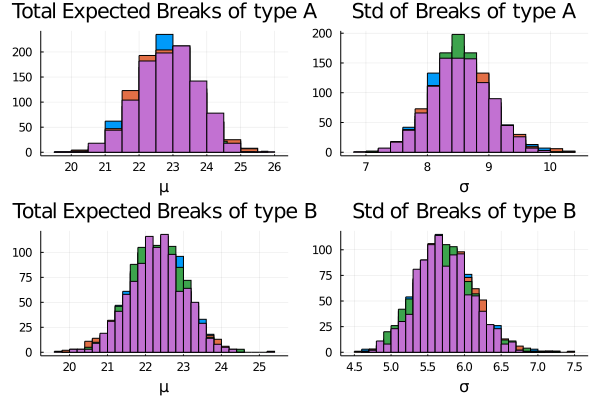

In [83]:
let
    plot(layout=4)
    histogram!(chn_a[:μ], xlabel="μ", label=missing,  subplot=1, title="Total Expected Breaks of type A")
    histogram!(chn_a[:σ], xlabel="σ", label=missing, subplot=2, title="Std of Breaks of type A")
    histogram!(chn_b[:μ], xlabel="μ", label=missing,  subplot=3, title="Total Expected Breaks of type B")
    histogram!(chn_b[:σ], xlabel="σ", label=missing, subplot=4, title="Std of Breaks of type B")
end

In [67]:
# WOOL SEPARATE MODEL OF TOTAL BREAKS FOR EACH TYPE
@model function wool_hirerchial(breaks_groups)
    τ ~ LogNormal(0, 10)  # Groups difference factor
    
    μ ~ Normal(20, 5)  # Breaks total average
    σ ~ LogNormal(5, 1)  # Breaks total std.
    η ~ MvNormal([0, 0], 1)  # Group difference
    
    θ = μ .+ τ .* η  # Constructed Hyperparameter

    for i in eachindex(breaks_groups)
        for j in eachindex(breaks_groups[i])
            breaks_groups[i][j] ~ Normal(θ[i], σ)
        end
    end
end

wool_hirerchial (generic function with 1 method)

In [68]:
# CHAIN BREAKS HIRERCHIAL
chn = sample(wool_hirerchial([breaks_a, breaks_b]), NUTS(), MCMCThreads(), 1000, 4)

┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC C:\Users\nitsa\.julia\packages\AbstractMCMC\Nw3Wn\src\sample.jl:228
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\nitsa\.julia\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\nitsa\.julia\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\nitsa\.julia\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.0015625
└ @ Turing.Inference C:\Users\nitsa\.julia\packages\Turing\PyTy2\src\inference\hmc.jl:188
┌ Info: Found initial s

Chains MCMC chain (1000×17×4 Array{Float64,3}):

Iterations        = 1:1000
Thinning interval = 1
Chains            = 1, 2, 3, 4
Samples per chain = 1000
parameters        = η[1], η[2], μ, σ, τ
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat 
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64 

        η[1]    0.2290    1.0334     0.0163    0.0665   200.2842    1.0244
        η[2]   -0.1383    1.0073     0.0159    0.0349   961.5439    1.0091
           μ   26.9815    1.7565     0.0278    0.0781   610.3040    1.0073
           σ   13.6571    1.4000     0.0221    0.0508   790.5277    1.0063
           τ    0.9330    2.7453     0.0434    0.2237    96.3869    1.0514

Quantiles
  parameters      2.5%     25.0%     50.0% 

In [70]:
# AVERAGE BREAKS
sum(df.Breaks) / length(df.Breaks)

28.14814814814815

In [71]:
# STD BREAKS
std(df.Breaks)

13.198638305132597

### Posterior of Wool Breaks, under Hirerchial Model, with out Wrap tension

##### Posterior Statistics of hirarchial model results

In [72]:
# POSTERIOR CONSTRUCTED HYPYERPARAMETER VALUE
θmean = mean(chn[:μ]) .+ mean(chn[:τ]) .* mean(Array(group(chn, :η))) # Constructed Hyperparameter
θstd = std(chn[:μ]) .+ std(chn[:τ]) .* std(Array(group(chn, :η))) # Constructed Hyperparameter

# DIVIDE PARAMETER η TO GROUP A AND GROUP B
η1, η2 = fetch_η(chn)

(Any[-0.5115677884884321, 0.0309244396074132, -0.4398251325117577, 1.9611361156378528, -0.4396460015274706, 0.2857084737184362, 0.7314765677223158, -1.0561549101288366, 0.24107071100756372, -0.08322755839743909  …  -0.05960089777608707, -0.31991154061833066, -1.7182672054230945, -2.5980533499198852, -2.5980533499198852, -2.005938528930307, -2.635198652271658, -2.635198652271658, -1.4333889347330466, 1.598742008598671], Any[-0.3617408588308405, -0.3627951804877598, 0.0840570600767381, 1.9611361156378528, 1.325007430220458, 0.05817758377019733, 0.2857084737184362, 0.7314765677223158, -0.8166468376212073, -0.08528946257223835  …  -0.6680475518890177, -0.429369731649799, -1.0638204665750082, -2.5980533499198852, -2.5980533499198852, -2.5980533499198852, -2.005938528930307, -2.635198652271658, -1.9417137343582018, -1.4333889347330466])

In [73]:
print(
    "Posterior Statisitcs:\n\n",
    "θ Hyperparameter (total average, μ .+ τ .* η):\n",
    "Average: ", θmean, "\n",
    "Std.: ", θstd,
    
    "\n\nσ Parameter (Breaks total std.):\n",
    "Average: ", sum(chn[:σ]) / length(chn[:σ]), "\n",
    "Std.: ", std(chn[:σ]), "\n\n",
    
    "τ Parameter (Groups difference factor):\n",
    "Average: ", sum(chn[:τ]) / length(chn[:τ]), "\n",
    "Std.: ", std(chn[:τ]),
    
    "\n\nμ Parameter (Breaks total average):\n",
    "Average: ", sum(chn[:μ]) / length(chn[:μ]), "\n",
    "Std.: ", std(chn[:μ]),
        
    "\n\nη Parameter (Groups difference):\n",
    "Average: ", sum(η) / length(η), "\n",
    "Std.: ", std(η),
    
    "\n\nη Parameter (Group A difference):\n",
    "Average: ", sum(η1) / length(η1), "\n",
    "Std.: ", std(η1),
    
    "\n\nη Parameter (Group B difference):\n",
    "Average: ", sum(η2) / length(η2), "\n",
    "Std.: ", std(η2),
)

Posterior Statisitcs:

θ Hyperparameter (total average, μ .+ τ .* η):
Average: 27.02382887946621
Std.: 4.602788430179059

σ Parameter (Breaks total std.):
Average: 13.657052964520389
Std.: 1.3999895304155776

τ Parameter (Groups difference factor):
Average: 0.9329905048786802
Std.: 2.7453063340440615

μ Parameter (Breaks total average):
Average: 26.9815447729528
Std.: 1.7564761347779236

η Parameter (Groups difference):
Average: 0.108888003673123
Std.: 0.9394562188228406

η Parameter (Group A difference):
Average: 0.055416436274601466
Std.: 1.0397650021006353

η Parameter (Group B difference):
Average: 0.03522565770663398
Std.: 1.0338423201464284

##### Posterior Plotting of the hirerchial model results

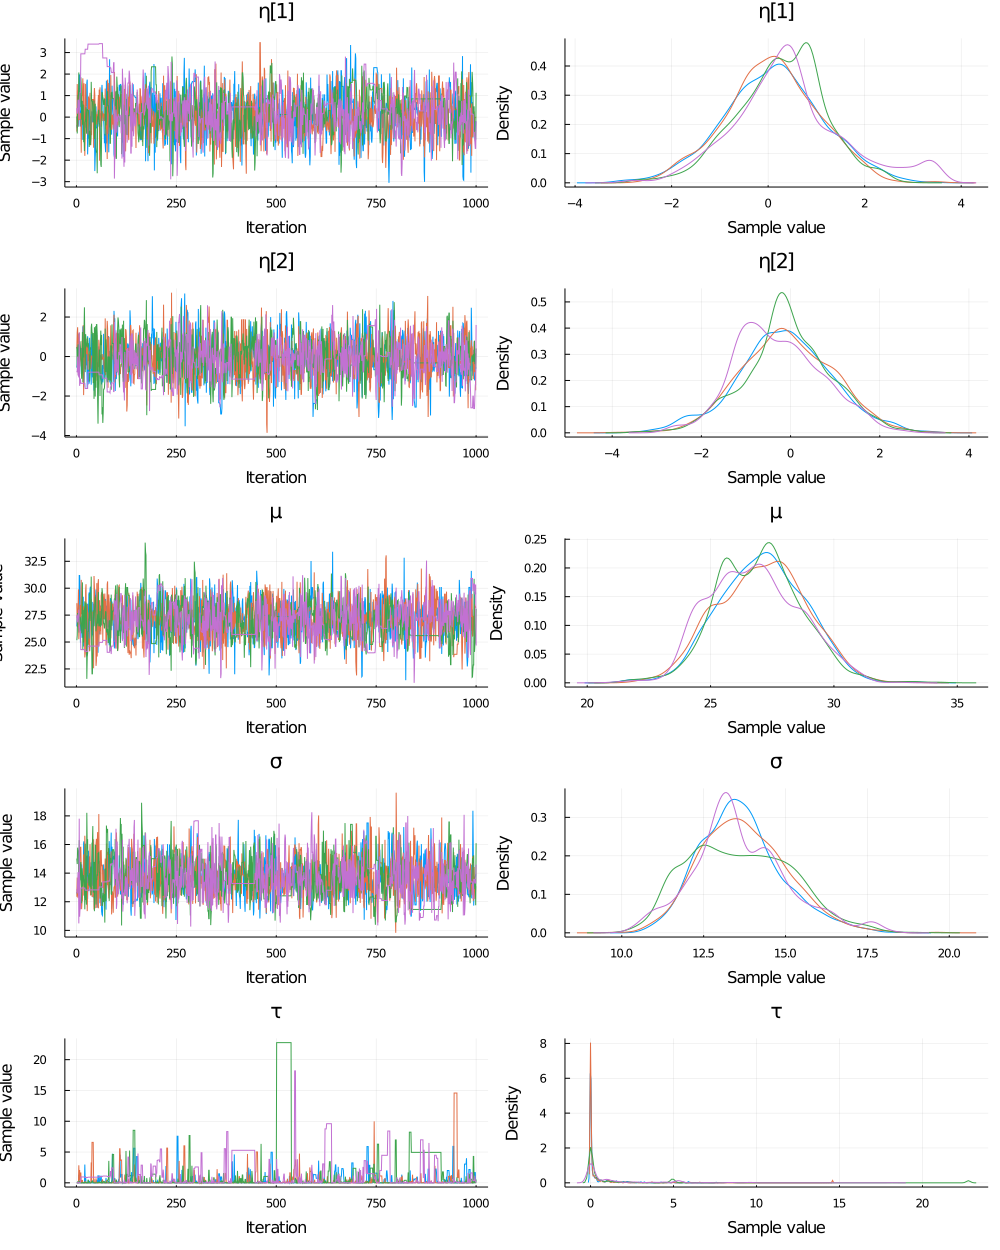

In [74]:
# PLOT CHAIN PARAMETERS
plot(chn)

#### Account for warp tension in both the hierarchical model and the separate model.

In [29]:
# WOOL SEPARATE MODEL OF TOTAL BREAKS FOR EACH TYPE WITH TENSION ACCOUNT
@model function wool_separate_tension(breaks, tension)    
    α0 ~ Normal(0, 1.5)
    
    αm ~ Normal(0, 1.5)
    αh ~ Normal(0, 1.5)
    
    for i in eachindex(breaks)
        μ ~ Normal(α0, 5)
        σ ~ Exponential(2)
        
        if tension[i] == "M"
            μm ~ Normal(αm, 5)
            μ += μm
        elseif tension[i] == "H"
            μm ~ Normal(αm, 5)
            μh ~ Normal(αh, 5)
            μ += μm + μh
        end
        
        breaks[i] ~ Normal(μ, σ)
    end
end

wool_separate_tension (generic function with 1 method)

In [30]:
# CHAIN BREAKS OF TYPE A AND B
chn_a_tens = sample(wool_separate_tension(breaks_a, tension_a), NUTS(), MCMCThreads(), 1000, 4)
chn_b_tens = sample(wool_separate_tension(breaks_b, tension_b), NUTS(), MCMCThreads(), 1000, 4)

┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC C:\Users\nitsa\.julia\packages\AbstractMCMC\Nw3Wn\src\sample.jl:228
┌ Info: Found initial step size
│   ϵ = 0.025
└ @ Turing.Inference C:\Users\nitsa\.julia\packages\Turing\PyTy2\src\inference\hmc.jl:188
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\nitsa\.julia\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\nitsa\.julia\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\nitsa\.julia\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Warning: The current prop

Chains MCMC chain (1000×19×4 Array{Float64,3}):

Iterations        = 1:1000
Thinning interval = 1
Chains            = 1, 2, 3, 4
Samples per chain = 1000
parameters        = α0, αh, αm, μ, μh, μm, σ
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat 
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64 

          α0    9.8199    1.3435     0.0212    0.0271   2657.9909    1.0023
          αh   -0.2284    1.4174     0.0224    0.0254   2895.0131    0.9998
          αm    3.6474    1.3166     0.0208    0.0289   2575.2172    1.0019
           μ   13.8584    1.5045     0.0238    0.0295   2413.1969    1.0017
          μh   -0.5475    1.8564     0.0294    0.0384   2568.8355    1.0003
          μm    5.9059    1.5197     0.024

In [31]:
# PRINT DATA STATISTICS
print(
    "breaks_a_tension_h mean: ", mean(breaks_a_tension_h), "\n",
    "breaks_a_tension_h std.: ", std(breaks_a_tension_h), "\n\n",
    
    "breaks_a_tension_m mean: ", mean(breaks_a_tension_m), "\n",
    "breaks_a_tension_m std.: ", std(breaks_a_tension_m), "\n\n",
    
    "breaks_a_tension_l mean: ", mean(breaks_a_tension_l), "\n",
    "breaks_a_tension_l std.: ", std(breaks_a_tension_l), "\n\n",
    
    "breaks_b_tension_h mean: ", mean(breaks_b_tension_h), "\n",
    "breaks_b_tension_h std.: ", std(breaks_b_tension_h), "\n\n",
    
    "breaks_b_tension_m mean: ", mean(breaks_b_tension_m), "\n",
    "breaks_b_tension_m std.: ", std(breaks_b_tension_m), "\n\n",
    
    "breaks_b_tension_l mean: ", mean(breaks_b_tension_l), "\n",
    "breaks_b_tension_l std.: ", std(breaks_b_tension_l), "\n\n",
)

breaks_a_tension_h mean: 24.555555555555557
breaks_a_tension_h std.: 10.27267140415665

breaks_a_tension_m mean: 24.0
breaks_a_tension_m std.: 8.660254037844387

breaks_a_tension_l mean: 44.55555555555556
breaks_a_tension_l std.: 18.097728525364108

breaks_b_tension_h mean: 18.77777777777778
breaks_b_tension_h std.: 4.893306085301066

breaks_b_tension_m mean: 28.77777777777778
breaks_b_tension_m std.: 9.431036233863406

breaks_b_tension_l mean: 28.22222222222222
breaks_b_tension_l std.: 9.85872428078017



In [75]:
print("Parameters Statistics (Group A):\n")
print_parameters("α0", chn_a_tens[:α0])
print("\n")
print_parameters("αh", chn_a_tens[:αh])
print("\n")
print_parameters("αm", chn_a_tens[:αm])
print("\n")
print_parameters("μ", chn_a_tens[:μ])
print("\n")
print_parameters("μh", chn_a_tens[:μh])
print("\n")
print_parameters("μm", chn_a_tens[:μm])
print("\n")
print_parameters("σ", chn_a_tens[:σ])
print("\n")

print("Parameters Statistics (Group B):\n")
print_parameters("α0", chn_b_tens[:α0])
print("\n")
print_parameters("αh", chn_b_tens[:αh])
print("\n")
print_parameters("αm", chn_b_tens[:αm])
print("\n")
print_parameters("μ", chn_b_tens[:μ])
print("\n")
print_parameters("μh", chn_b_tens[:μh])
print("\n")
print_parameters("μm", chn_b_tens[:μm])
print("\n")
print_parameters("σ", chn_b_tens[:σ])

Parameters Statistics (Group A):
α0 Mean: 8.854100864514713
α0 Std.: 1.3791986472101434

αh Mean: 1.091384598208017
αh Std.: 1.4334187902283562

αm Mean: 2.562299219065121
αm Std.: 1.3335882821434049

μ Mean: 12.486017666235186
μ Std.: 1.5932413949505422

μh Mean: 2.408324825147779
μh Std.: 1.9616395490077942

μm Mean: 4.137531614506288
μm Std.: 1.576856488203983

σ Mean: 10.176629276479606
σ Std.: 0.5785105360053621

Parameters Statistics (Group B):
α0 Mean: 9.819892331206606
α0 Std.: 1.3434625856831348

αh Mean: -0.2284399708284621
αh Std.: 1.4174180004023138

αm Mean: 3.647425156526289
αm Std.: 1.316643594442632

μ Mean: 13.858377143446335
μ Std.: 1.504523816189935

μh Mean: -0.5474828990877585
μh Std.: 1.8564337346910753

μm Mean: 5.905919861099386
μm Std.: 1.5196792195384001

σ Mean: 6.871045187973201
σ Std.: 0.5134288349048638


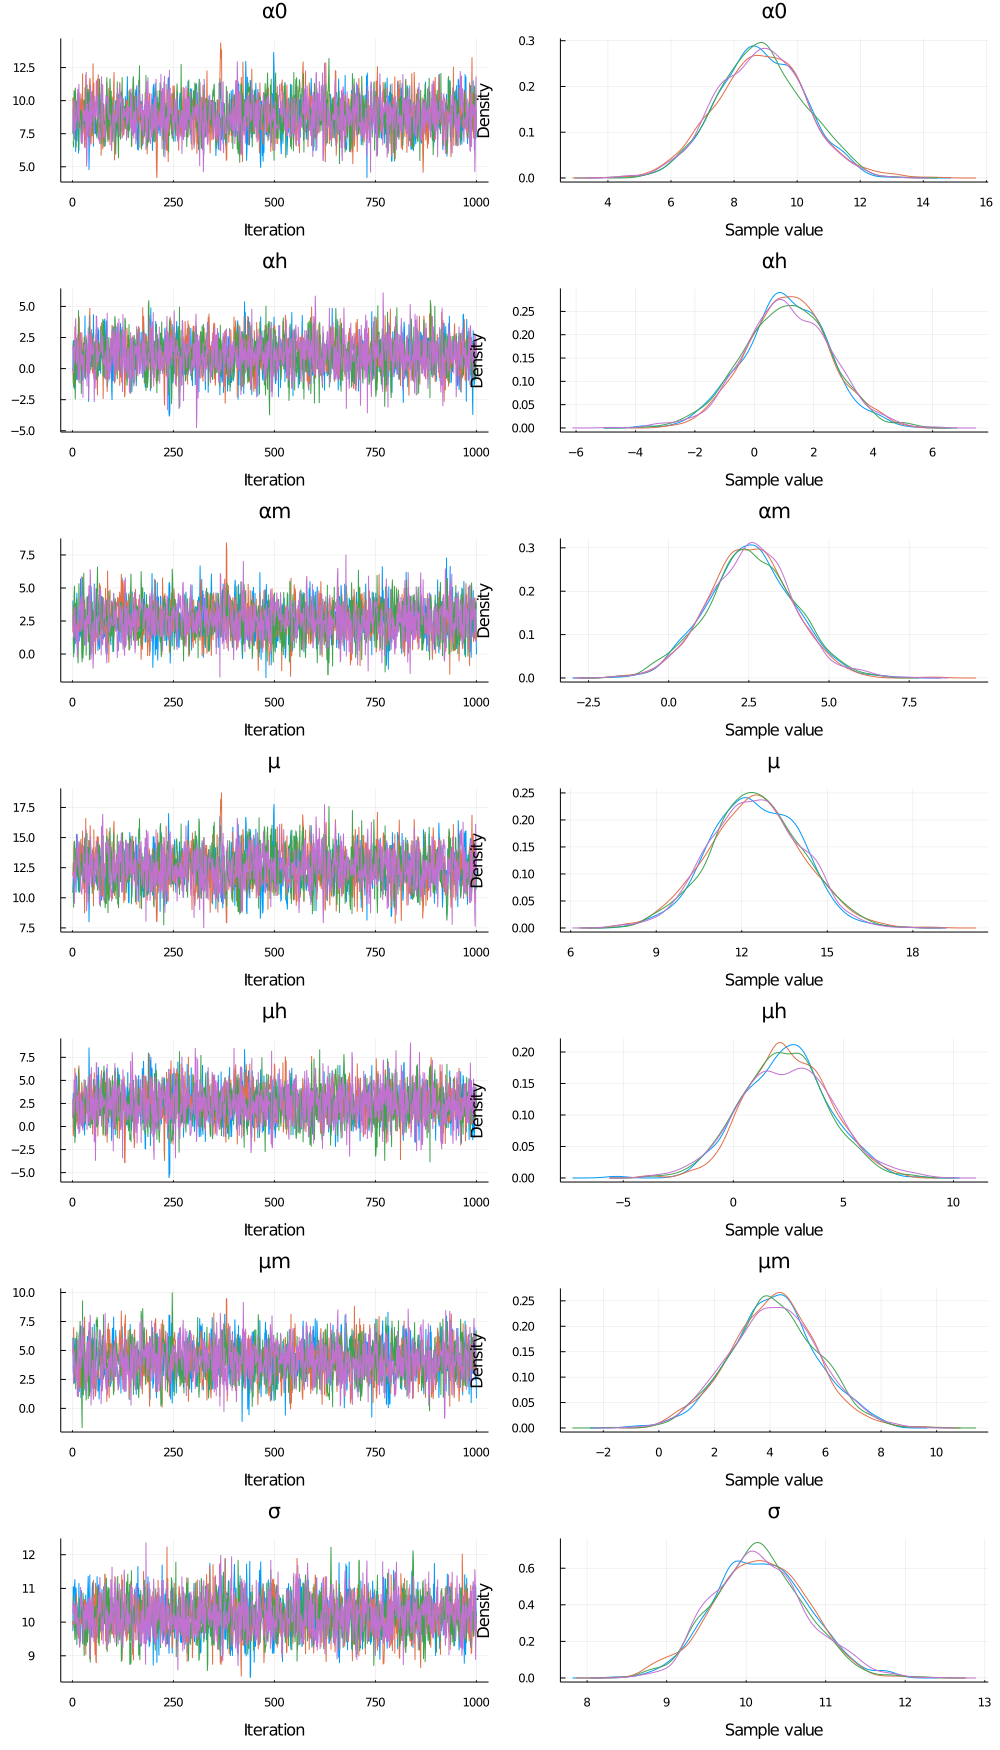

In [32]:
plot(chn_a_tens)

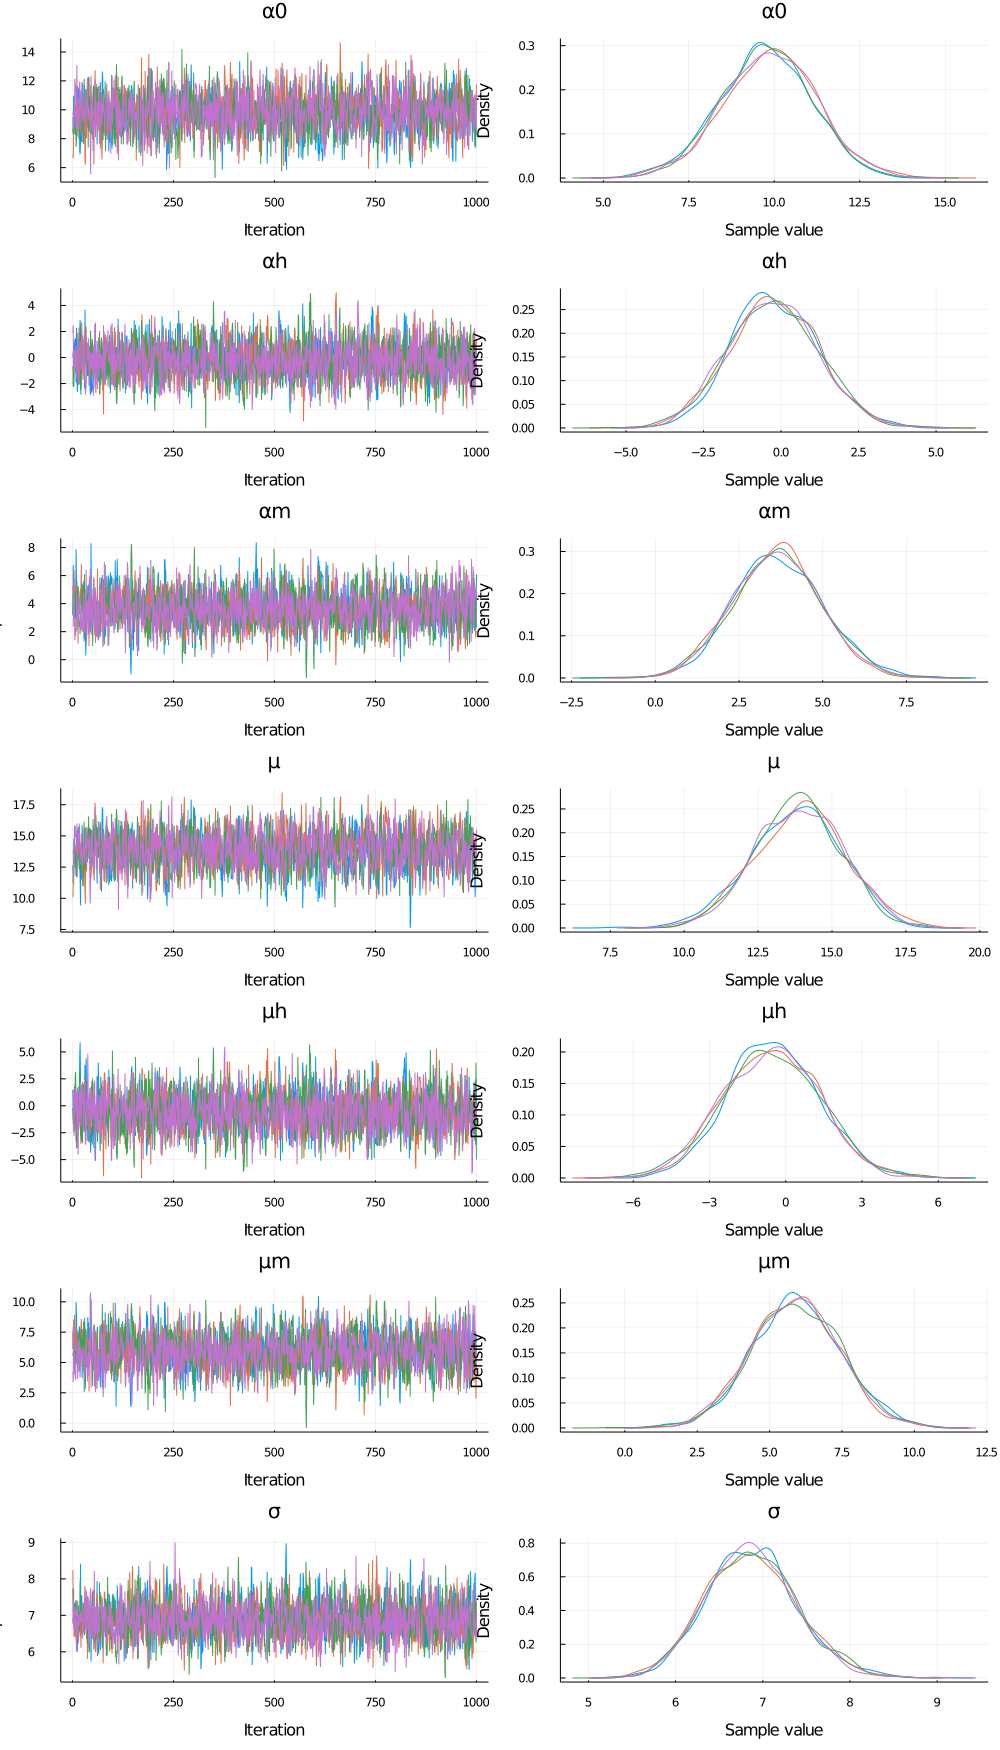

In [33]:
plot(chn_b_tens)

#### Account for warp tension in the hierarchical model.

In [35]:
# WOOL HIERARCHIAL MODEL OF TOTAL BREAKS FOR EACH TYPE
@model function wool_hierarchial_tension(breaks_groups, tension_groups)
    τ ~ LogNormal(0, 10)  # Groups difference factor
    
    μ ~ Normal(20, 5)  # Breaks total average
    σ ~ LogNormal(5, 1)  # Breaks total std.
    η ~ MvNormal([0, 0], 1)  # Group difference
    
    θ = μ .+ τ .* η  # Constructed Hyperparameter
    
    # TENSION
    αm ~ Normal(0, 1.5)
    αh ~ Normal(0, 1.5)

    for i in eachindex(breaks_groups)        
        for j in eachindex(breaks_groups[i])            
             θi = θ[i]

            if tension_groups[i][j] == "M"
                μm ~ Normal(αm, 5)
                θi += μm
            elseif tension_groups[i][j] == "H"
                μm ~ Normal(αm, 5)
                μh ~ Normal(αh, 5)
                θi += μm + μh
            end
            
            # TOTAL
            breaks_groups[i][j] ~ Normal(θi, σ)
        end
    end
end

wool_hierarchial_tension (generic function with 1 method)

In [38]:
# CHAIN BREAKS OF TYPE A AND B TENSION
chn_hier_tens = sample(wool_hierarchial_tension([breaks_a, breaks_b], [tension_a, tension_b]), 
    NUTS(), MCMCThreads(), 1000, 4)

┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC C:\Users\nitsa\.julia\packages\AbstractMCMC\Nw3Wn\src\sample.jl:228
┌ Info: Found initial step size
│   ϵ = 0.00625
└ @ Turing.Inference C:\Users\nitsa\.julia\packages\Turing\PyTy2\src\inference\hmc.jl:188
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, true, false)
└ @ AdvancedHMC C:\Users\nitsa\.julia\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\nitsa\.julia\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\nitsa\.julia\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Info: Found initial step 

Chains MCMC chain (1000×21×4 Array{Float64,3}):

Iterations        = 1:1000
Thinning interval = 1
Chains            = 1, 2, 3, 4
Samples per chain = 1000
parameters        = αh, αm, η[1], η[2], μ, μh, μm, σ, τ
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat 
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64 

          αh   -0.8245    1.3351     0.0211    0.0508   709.4318    1.0027
          αm   -0.8197    1.4814     0.0234    0.1159    46.6966    1.1016
        η[1]    0.2596    0.9249     0.0146    0.0415   344.2108    1.0228
        η[2]   -0.0418    0.9298     0.0147    0.0419   433.9427    1.0189
           μ   27.3268    3.2466     0.0513    0.4184    14.7573    1.4448
          μh   -1.4350    1.6630     0

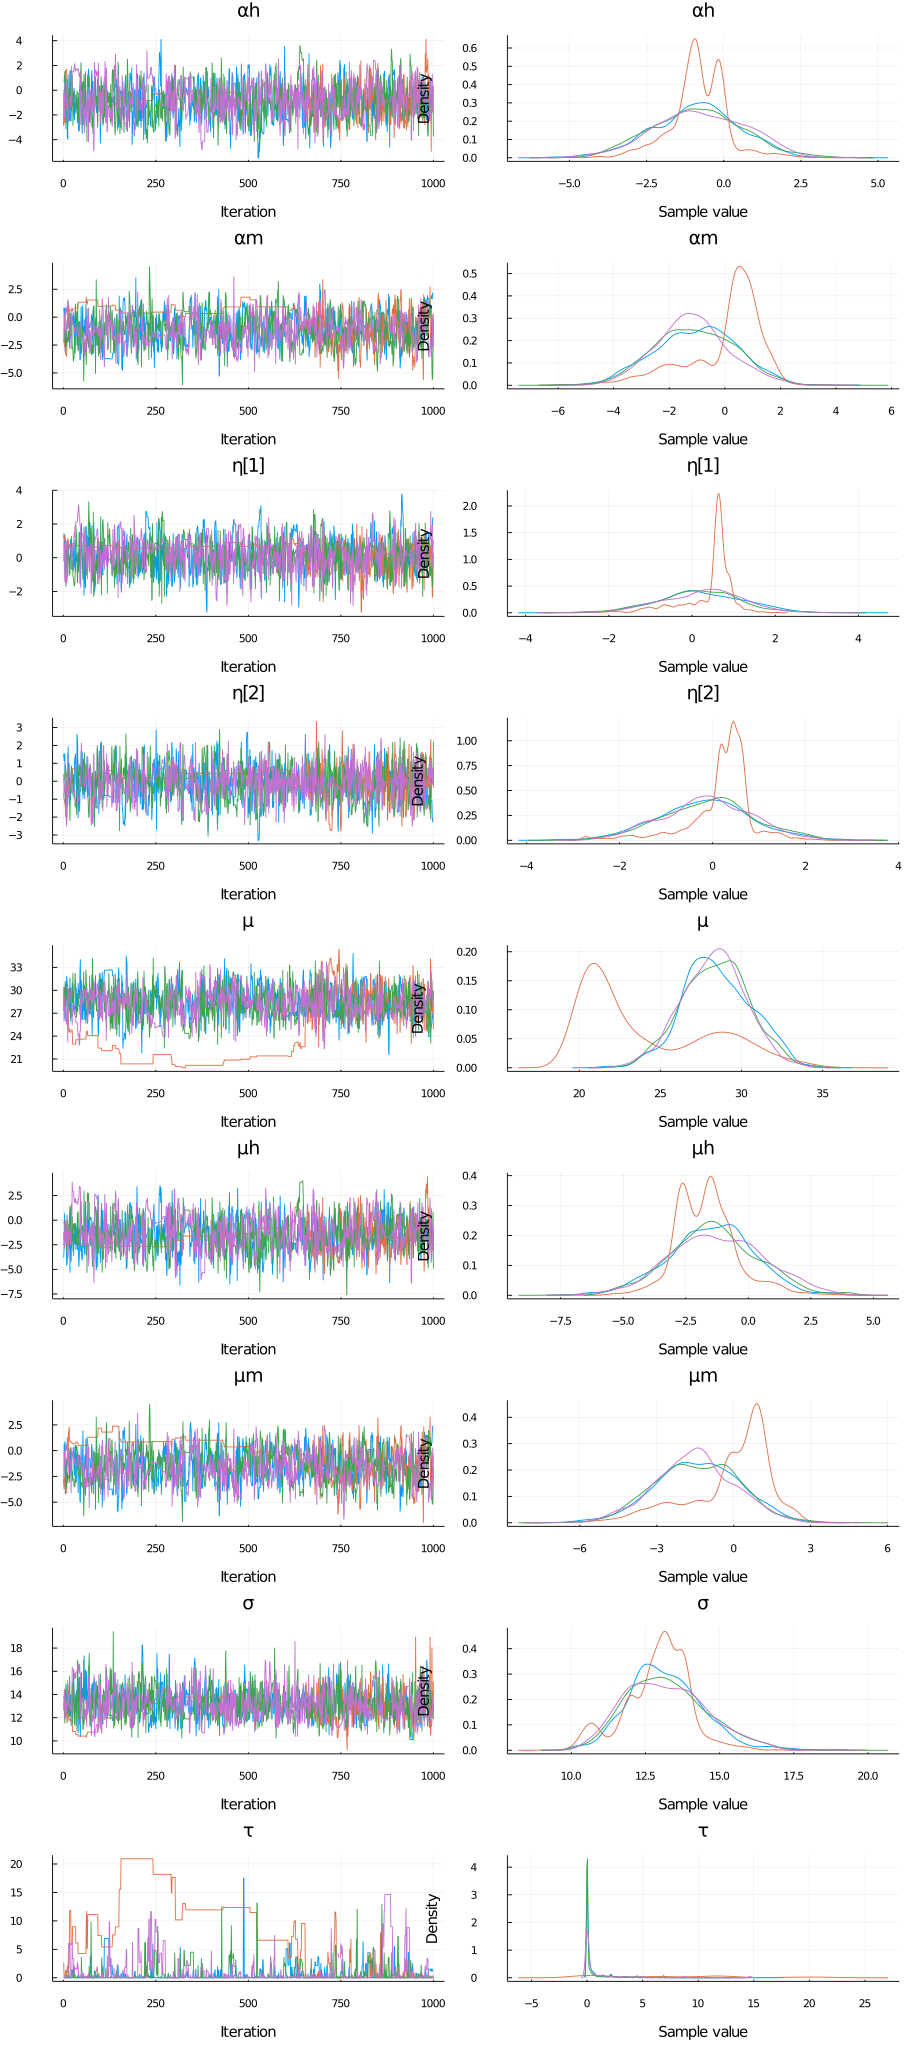

In [39]:
plot(chn_hier_tens)

In [63]:
η1, η2 = fetch_η(chn_hier_tens)

(Any[1.209091488452702, 1.4078299138869803, -0.6463095524954539, -0.5585998984081187, 1.060452078076482, 0.6652614535833483, 0.2931635641202411, -0.2445944663059672, -0.636126832517744, 0.8370895778355981  …  -1.5689974997235434, -1.2970907414862842, 0.7456277244996213, 0.8997461677329738, -0.25436986655992067, 1.1771064730945384, 0.7595515537725249, 0.14229473148725302, -0.2145082028613154, 0.6433025321496282], Any[1.3230948327462682, 0.3102116777683071, -1.0054347258282819, -0.7117009074271436, 0.46477428601305726, 0.9724498478526054, -0.2055600054734336, 0.10477446320127057, -0.44508321554509334, 1.096823015107899  …  -1.5689974997235434, -1.2970907414862842, -0.7092562732334684, 0.32536375074117085, 0.9664610481572085, -0.25872809321200935, 0.08031128299437618, 1.1781140506317802, 0.7737740788763605, 0.34401651490833396])

In [64]:
print("Parameters Statistics:\n")
print_parameters("αh", chn_hier_tens[:αh])
print("\n")
print_parameters("αm", chn_hier_tens[:αm])
print("\n")
print_parameters("η1", η1)
print("\n")
print_parameters("η2", η2)
print("\n")
print_parameters("μ", chn_hier_tens[:μ])
print("\n")
print_parameters("μh", chn_hier_tens[:μh])
print("\n")
print_parameters("μm", chn_hier_tens[:μm])
print("\n")
print_parameters("σ", chn_hier_tens[:σ])
print("\n")
print_parameters("τ", chn_hier_tens[:τ])

Parameters Statistics:
αh Mean: -0.8244659685627835
αh Std.: 1.3350532334656553

αm Mean: -0.8197050627357181
αm Std.: 1.4813958107100043

η1 Mean: 0.10553977177819476
η1 Std.: 0.931910765673002

η2 Mean: 0.11223623556805108
η2 Std.: 0.9470462352725424

μ Mean: 27.326795777130997
μ Std.: 3.24656304042445

μh Mean: -1.4350441758379306
μh Std.: 1.6630272124022656

μm Mean: -1.1159343359449359
μm Std.: 1.7017716525262563

σ Mean: 13.12962370926446
σ Std.: 1.2832338732862891

τ Mean: 2.5242040068309888
τ Std.: 4.863418377244134


## Problem 2: City of Norfolk employee salaries

City of Norfolk provides access to  [employee salary data](https://data.norfolk.gov/Government/Employee-Salaries/4fsk-z8s8).

Analyze the salary distributions.

1. by department.
2. by department and employee status.
3.  Compare the analysis under separate and hierarchical models.
4. A small number of groups are very different from the rest, how do you propose to handle the difference in the hierarchical model?

In [2]:
# FETCH DATA
employee_salaries = CSV.File("data/employee_salaries.csv") |> DataFrame

4399×7 DataFrame
  Row │ Department                      Position Title                Employee ⋯
      │ String                          String                        String   ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │ CF - MacArthur Memorial         Museum Attendant              Casual P ⋯
    2 │ CF - MacArthur Memorial         Museum Attendant              Casual P
    3 │ CF - MacArthur Memorial         Museum Attendant              Permanen
    4 │ CF - MacArthur Memorial         Museum Attendant              Permanen
    5 │ CF - MacArthur Memorial         Administrative Technician     Permanen ⋯
    6 │ CF - MacArthur Memorial         Curator                       Permanen
    7 │ CF - MacArthur Memorial         Education Manager             Permanen
    8 │ CF - MacArthur Memorial         Archivist                     Permanen
    9 │ CF-Cultural&Convention Center   Ticket Seller                 Intermit ⋯
   10 │ CF-Cultural&Convention Center   Ticket Sales Supervisor       Intermit
   11 │ CFAE-Cultural Affrs/SpecEvents  Public Information Spec I     Permanen
  ⋮   │               ⋮                              ⋮                         ⋱
 4390 │ Victim Services Grant           Paralegal CWA                 Special
 4391 │ Victim Services Grant           Paralegal CWA                 Special  ⋯
 4392 │ Victim/Witness Program          Victim/Witness Prog Asst Dir  Special
 4393 │ Zoo- Operations                 Security Officer              Permanen
 4394 │ Zoo- Operations                 Security Officer              Permanen
 4395 │ Zoo-Veterinary & Wellness Camp  Zookeeper                     Permanen ⋯
 4396 │ Zoo-Veterinary & Wellness Camp  Veterinary Technician         Permanen
 4397 │ Zoo-Veterinary & Wellness Camp  Zookeeper                     Permanen
 4398 │ Zoo-Veterinary & Wellness Camp  Veterinary Technician         Permanen
 4399 │ Zoo-Veterinary & Wellness Camp  Veterinarian                  Permanen ⋯
                                                 5 columns and 4378 rows omitted

In [3]:
# FETCH COLUMNS
departments = employee_salaries[!, 1]
position = employee_salaries[!, 2]
status = employee_salaries[!, 3]
date_start = employee_salaries[!, 4]
date_end = employee_salaries[!, 5]
tax = employee_salaries[!, 6]
salary = employee_salaries[!, 7]

# UNIQUE DEPARTMENTS
unique_departments = unique(departments)

# AVERAGE SALARY FOR EACH DEPARTMENTS
average_salaries = []

for i in eachindex(unique_departments)
    department = unique_departments[i]
    department_indices = findall(d -> (d == department), departments)
    
    department_salary = 0
    for j in eachindex(department_indices)
        department_salary += salary[j]
    end
    
    department_salary /= length(department_indices)
    
    push!(average_salaries, department_salary)
end

In [13]:
unique_departments

165-element Array{String,1}:
 "CF - MacArthur Memorial"
 "CF-Cultural&Convention Center"
 "CFAE-Cultural Affrs/SpecEvents"
 "Cemetery Fund"
 "Circuit Court Judges"
 "City Assessor"
 "City Auditor"
 "City Clerk"
 "City Council"
 "City Manager-NCJS Adlt Com Sup"
 "City Manager-NCJS Pretrial Svc"
 "City Planning - Dir Office"
 "City Treasurer"
 ⋮
 "Utilities Engineering"
 "Utilities WasteWater"
 "Utilities Water Accounts"
 "Utilities Water Distribution"
 "Utilities Water Production"
 "Utilities Water Quality"
 "VOCA Victim Services"
 "VSTOP"
 "Victim Services Grant"
 "Victim/Witness Program"
 "Zoo- Operations"
 "Zoo-Veterinary & Wellness Camp"

In [14]:
average_salaries

165-element Array{Any,1}:
 32790.66625
    12.51
    12.51
 27683.950952380957
 26235.183
 28472.0216
 29148.58222222222
 26235.183
 28658.17285714286
 32790.66625
 32790.66625
    12.51
 29114.550000000003
     ⋮
 40843.53622222223
 50780.74098765433
 27539.228500000005
 48584.3538888889
 50972.00512195123
 29148.58222222222
    12.51
    12.51
    12.51
    12.51
    12.51
 17175.816

In [39]:
mean(average_salaries)

21703.684807196034

In [40]:
std(average_salaries)

15721.732873687766

In [8]:
# SALARIES MODEL
# salary dist. depend on department
@model function salaries(average_salaries)         
    σ0 ~ Exponential(1)
    σ1 ~ Exponential(1)
    α0 ~ Normal(0, 1.5)
    
    αt ~ MvNormal(fill(α0, length(average_salaries)), σ0)
    σt ~ MvLogNormal(fill(σ0, length(average_salaries)), σ1)
    
    for i in eachindex(average_salaries)
        average_salaries[i] ~ Normal(αt[i], σt[i])
    end
end

salaries (generic function with 1 method)

In [ ]:
# TODO - Make model learn at a likely time
chn_salaries = sample(salaries(average_salaries), NUTS(), MCMCThreads(), 1000, 4)

┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC C:\Users\nitsa\.julia\packages\AbstractMCMC\Nw3Wn\src\sample.jl:228
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\nitsa\.julia\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\nitsa\.julia\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\nitsa\.julia\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\ni

In [ ]:
plot(chn_salaries)

In [58]:
# TODO - Print Parameters statistics
# print("Parameters Statistics:\n")
# print_parameters("μ", chn_salaries[:μ])
# print("\n")
# print_parameters("σ", chn_salaries[:σ])

Parameters Statistics:
μ Mean: -0.5233558685581448
μ Std.: 6.664671316910112e-16

σ Mean: 2.275490352674267
σ Std.: 2.6658685267640448e-15
